# Chignolin MFPTs after clustering
This is a modification of the notebook given Chris (christoph.wehmeyer@fu-berlin.de), in this case we are going to use is to cluster the microstates based on the commute times.

In [1]:
import sys
import math
sys.path.append("/Users/suarezalvareze2/Documents/workspace/NMpathAnalysis/nmpath")
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pyemma
import mdtraj as md
from glob import glob

# My modules
from auxfunctions import *
from mfpt import *
from clustering import *
from nmm import NonMarkovModel, MarkovPlusColorModel

# Print 
from IPython.display import Markdown, display

## Auxiliary functions


In [2]:
def get_lagtime_from_array(lags, lagtime, dt=0.2):
    idx = np.argmin(np.abs(lags * dt - lagtime))
    return idx, lags[idx]

def printmd(string):
    display(Markdown(string))

def plot_t_AB(t_cut_values, t_min_list, t_max_list, t_AB_list, tAB_interval=None):
    t_cut_values_ns = np.array(t_cut_values)*dt
    t_min_list_ns = np.array(t_min_list)*dt
    t_max_list_ns = np.array(t_max_list)*dt
    t_AB_list_ns = np.array(t_AB_list)*dt

    fig = plt.figure(figsize=(15,3))

    ax1 =  fig.add_subplot(131)
    ax1.plot(t_cut_values_ns , t_AB_list_ns, "-o")
    ax1.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax1.set_ylabel("$t_{AB}\mathrm{(ns)}$", fontsize = 18)
    if tAB_interval is not None:
        ax1.set_ylim(tAB_interval[0],tAB_interval[1])
    #ax1.set_xlim(40,105)

    ax2 =  fig.add_subplot(132)
    ax2.plot(t_cut_values_ns, t_AB_list_ns/t_cut_values_ns, "-o",c="r")
    ax2.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax2.set_ylabel("$t_{AB} / t_{cut}$", fontsize = 18)
    #ax2.set_xlim(40,105)

    ax3 =  fig.add_subplot(133)
    ax3.plot(t_cut_values_ns, t_max_list_ns/t_cut_values_ns, "-o",c="g")
    ax3.set_xlabel("$t_{cut}\mathrm{(ns)}$", fontsize = 18)
    ax3.set_ylabel("$t_{max} / t_{cut}$", fontsize = 18)
    #ax3.set_xlim(40,105)

    plt.show()


def plot_rmsd_histogram_clusters(t_cut_values, big_clusters_list, rmsd, dt, dtrajs):
    max_ = len(t_cut_values)
    select_to_plot= range(0, max_ ,3) # This will print the first column of the free energy plots


    for i in select_to_plot:
        macrostates = big_clusters_list[i]
        rmsd_cluster0=[]
        rmsd_cluster1=[]

        for j, microstate in enumerate(dtrajs[0]):  # There is only one traj
            if microstate in macrostates[0]:
                rmsd_cluster0.append(rmsd[j])
            elif (len(macrostates) > 1) and microstate in macrostates[1]:
                rmsd_cluster1.append(rmsd[j])

        fig = plt.figure(figsize=(5,2))

        plt.hist(rmsd_cluster0,normed=True, bins=25, color="r", 
                 alpha=0.5,label="cluster-0", edgecolor="r")
        if len(macrostates) > 1:
            plt.hist(rmsd_cluster1,normed=True, bins=25, color="b", 
                     alpha=0.5,label="cluster-1", edgecolor="b")

        plt.xlabel("RMSD$(\AA)$",fontsize=12)
        plt.ylabel("Probability Dens.",fontsize=12)
        plt.legend()
        #plt.title("t_cut: {:.2f}ns".format(t_cut_values_ns[i]))
        plt.annotate("t_cut: {:.2f}ns".format(t_cut_values[i]*dt), xy=(1,2))
        plt.xlim([0,7])
        plt.show()


color_sequence = ['#d62728', '#ff9896', '#9467bd',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5', '#98df8a']
color_sequence+=color_sequence

## Create a feature reader

We create a feature reader to obtain minimal distances between all residues which are not close neighbours. Feel free to map these distances to binary contacts or use inverse minimal residue distances instead. These coices usually work quite well.

In [3]:
traj_files = [f for f in sorted(glob('../../../DESHAWTRAJS/CLN025-0-protein/CLN025-0-protein-*.dcd'))]
pdb_file = '../../../DESHAWTRAJS/CLN025-0-protein/chig_pdb_166.pdb'


features = pyemma.coordinates.featurizer(pdb_file)
features.add_residue_mindist()
source = pyemma.coordinates.source([traj_files], features=features, chunk_size=10000)

29-11-17 16:09:17 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  Using all residue pairs with schemes like closest or closest-heavy is very time consuming. Consider reducing the residue pairs


## Discretization and MSM estimation

We start the actual analysis with a TICA projection onto two components on which we perform a k-means clustering. Then, we take a quick view on the implied timescale convergence, the 2D representation, and the clustering:

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

29-11-17 16:10:02 pyemma.coordinates.clustering.kmeans.KmeansClustering[3] INFO     Cluster centers converged after 19 steps.


A Jupyter Widget

A Jupyter Widget

/Users/suarezalvareze2/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


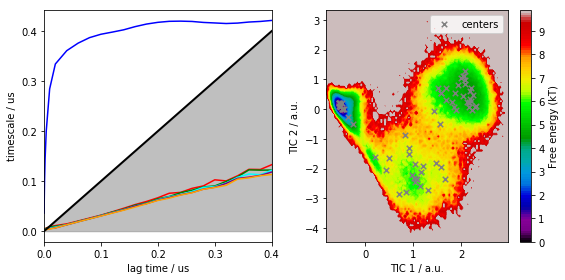

In [4]:
tica = pyemma.coordinates.tica(data=source, lag=5, dim=10).get_output()[0]
cluster = pyemma.coordinates.cluster_kmeans(tica, k=64, max_iter=100)

lags = np.asarray([1, 5, 10, 20, 50] + [i * 100 for i in range(1, 21)])
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
pyemma.plots.plot_implied_timescales(
    pyemma.msm.its(cluster.dtrajs, lags=lags, errors=None, nits=6),
    ylog=False, ax=axes[0], units='us', dt=2.0E-4)
pyemma.plots.plot_free_energy(*tica[:, :2].T, ax=axes[1])
axes[1].scatter(*cluster.clustercenters[:,:2].T, marker='x', c='grey', s=30, label='centers')
axes[1].legend()
axes[1].set_xlabel('TIC 1 / a.u.')
axes[1].set_ylabel('TIC 2 / a.u.')
fig.tight_layout()

# MSM estimation
msm = [pyemma.msm.estimate_markov_model(cluster.dtrajs, lag=lag, dt_traj='0.0002 us') for lag in lags]